In [1]:
# Deep Learning for Autonomous Driving
# Project 1: Understanding Multimodal Driving Data

In [109]:
%matplotlib inline
import os
import io
import math
import pickle
import PIL.Image
import cv2 as cv
import numpy as np
from load_data import load_data
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display

def load_data(data_path):
    # Load data dictionary from data_path.
    with open(data_path, 'rb') as fp:
        data = pickle.load(fp)
    return data

# https://stackoverflow.com/questions/34643747/ipython-notebook-jupyter-opencv-cv2-and-plotting
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# OpenCV documentation https://docs.opencv.org/master/
# Note that it's mainly written with C/C++ in mind. However, Python functions are given as well.

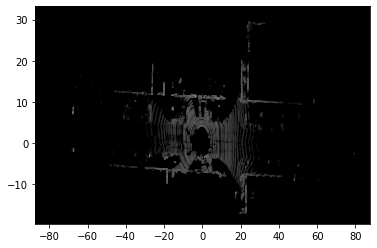

In [110]:
# Problem 1. Bird's Eye View

# load data
segmentation_data_path = os.path.join('data', 'segmentation_data.p')
segmentation_data = load_data(segmentation_data_path)

# point cloud of the scene of type (x [m], y [m], z [m], reflectance intensity [0,1]), (num_points x 4) numpy.array object
velodyne = segmentation_data["velodyne"]

# This should be the right colormapping, therefore the right result!
plt.scatter(
    velodyne[:,0],
    velodyne[:,1],
    s = 0.01,
    c = 255*velodyne[:,3],
    cmap = 'gray'
)

ax = plt.gca()
ax.set_facecolor((0, 0, 0))

# save the figure in the same folder
plt.savefig('BIW0.01.png')

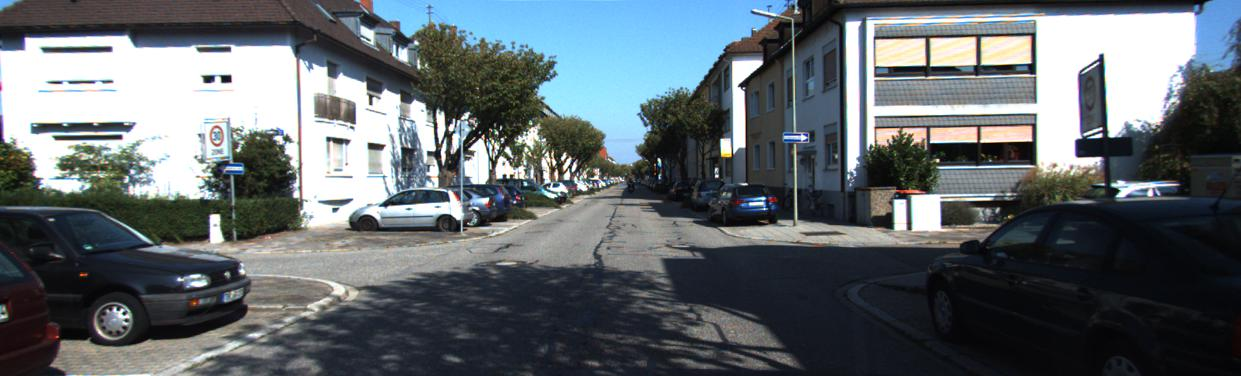

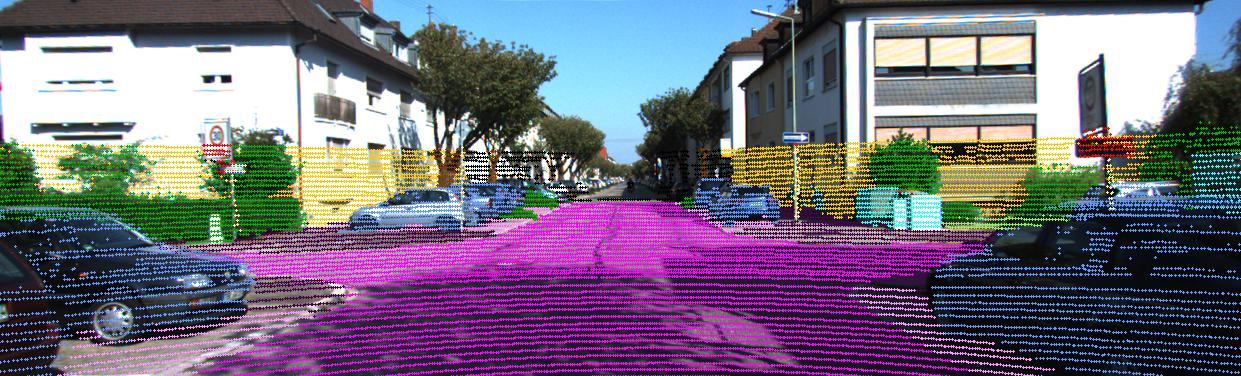

In [111]:
# Problem 2. Projection onto Image Plane
# a. Semantic Segmentation: Displaying Semantic Labels

# load data
segmentation_data_path = os.path.join('data', 'segmentation_data.p')
segmentation_data = load_data(segmentation_data_path)

# point cloud of the scene of type (x [m], y [m], z [m], reflectance intensity [0,1]), (num_points x 4) numpy.array object
velodyne = segmentation_data["velodyne"]

# RGB image received from left RGB camera (1 image per 360° velodyne rotation)
image_2 = segmentation_data["image_2"]

# intrinsic projection matrix to Cam 2 after rectification, (3x4) numpy.array object
P_rect_20 = segmentation_data["P_rect_20"]

# homogeneous velodyne to rectified camera 2 coordinate transformation, (4x4) numpy.array object
T_cam2_velo = segmentation_data["T_cam2_velo"]

# semantic label of each point within the scene, (num_points,) numpy.array object
sem_labels = segmentation_data["sem_label"]

# dictionary mapping numeric semantic labels -> BGR (reversed RGB) color for visualization (e.g. 10: [245, 150, 100])
color_map = segmentation_data["color_map"]

# dictionary mapping numeric semantic labels -> string class (e.g. 10: "car")
labels = segmentation_data["labels"]

# computer vision naming scheme:
#    X is a 3d point
#    x is a 2d point
#    Xh is a 3d homogeneous point
#    xh is a 2d homogeneous point
Xh_world = np.copy(velodyne)
Xh_world[:, 3] = 1

# Velodyne scans are 360°, so we need to get rid of all points that are behind cam2 
# => retain only points whose x-value >= 0.27 (world coordinates)
retain_indices = ( Xh_world[:,0] >= 0.27 )

# project the 3d homogeneous points (world coordinates) to 3d homogeneous points (cam2 coordinates)
Xh_rectified_cam2 = np.matmul(T_cam2_velo, np.transpose(Xh_world))

# normalize such that homogeneous coordinate is 1.0 again
Xh_rectified_cam2[0,:] = Xh_rectified_cam2[0,:] / Xh_rectified_cam2[3,:]
Xh_rectified_cam2[1,:] = Xh_rectified_cam2[1,:] / Xh_rectified_cam2[3,:]
Xh_rectified_cam2[2,:] = Xh_rectified_cam2[2,:] / Xh_rectified_cam2[3,:]
Xh_rectified_cam2[3,:] = Xh_rectified_cam2[3,:] / Xh_rectified_cam2[3,:]

# project the 3d homogeneous points (cam2 coordinates) to 2d homogeneous points on the rectified cam2 image plane
xh_rectified_cam2 = np.matmul(P_rect_20, Xh_rectified_cam2)

# normalize such that homogeneous coordinate is 1.0 again
xh_rectified_cam2[0,:] = xh_rectified_cam2[0,:] / xh_rectified_cam2[2,:]
xh_rectified_cam2[1,:] = xh_rectified_cam2[1,:] / xh_rectified_cam2[2,:]
xh_rectified_cam2[2,:] = xh_rectified_cam2[2,:] / xh_rectified_cam2[2,:] # for the sake of completeness

# prune homogeneous coordinates
x_rectified_cam2 = xh_rectified_cam2[0:2]

# convert float32 -> int32 (implicit rounding)
x_rectified_cam2 = x_rectified_cam2.astype(np.int32)

# 1st index goes over each point and 2nd index goes over coordinates of the point
x_rectified_cam2 = np.transpose(x_rectified_cam2)
dimN = np.shape(x_rectified_cam2)[0]

# make a copy to be save
image_2_semantic_segmentation = np.copy(image_2)

# draw the velodyne points as semantic segmentation points (circles)
for i in range(dimN) :

    if not retain_indices[i] : continue

    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    sem_label = sem_labels[i]
    #print(sem_label[0])
    #label = labels[sem_label[0]]
    color = color_map[sem_label[0]]
    R = color[2] 
    G = color[1]
    B = color[0]

    cv.circle(
        img = image_2_semantic_segmentation,
        center = (x,y),
        radius = 1,
        color = (R,G,B),
        thickness = -1,
        lineType = cv.LINE_AA,
        shift = 0
    )

# write output and show results
cv.imwrite("image_2.png", image_2)
showarray(image_2)
cv.imwrite("image_2_semantic_segmentation.png", image_2_semantic_segmentation)
showarray(image_2_semantic_segmentation)

[['Car', 1.76, 1.77, 4.41, -3.82, 1.9, 19.65, 1.67], ['Car', 1.48, 1.65, 4.4, -2.63, 1.99, 27.12, 1.72], ['Car', 1.42, 1.66, 3.64, 0.67, 2.11, 43.31, 1.73], ['Car', 1.44, 1.64, 3.78, 7.44, 2.25, 66.05, 1.92], ['Cyclist', 1.78, 0.69, 1.81, 3.18, 1.87, 24.54, -1.51], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0]]


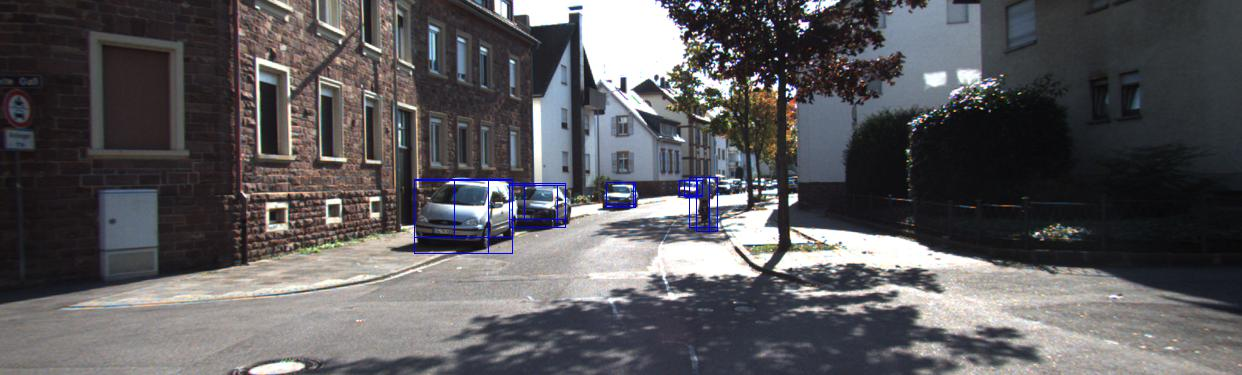

In [81]:
# Problem 2. Projection onto Image Plane
# b. Object Detection: Drawing 3D Bounding Boxes

# load data
detection_data_path = os.path.join("data", "detection_data.p")
detection_data = load_data(detection_data_path)

# RGB image received from left RGB camera (1 image per 360° velodyne rotation)
image_2 = detection_data["image_2"]

# intrinsic projection matrix to Cam 2 after rectification, (3x4) numpy.array object
P_rect_00 = detection_data["P_rect_00"]
P_rect_20 = detection_data["P_rect_20"]

# pinhole camera intrinsics from Cam 0 to Cam 2, (3x3) numpy.array object
K_cam0 = detection_data["K_cam0"]
K_cam2 = detection_data["K_cam2"]

# list of lists; each sublist has 8 columns of the following:
# ---------------------------------------------------------------------------------------------
# 1 type describes the type of object: ‘Car’, ‘Van’, ‘Truck’, ‘Pedestrian’, ‘Person sitting’, 
#                                      ‘Cyclist’, ‘Tram’, ‘Misc’ or ‘DontCare’
# 3 dimensions 3D object dimensions: height, width, length (in meters)
# 3 location 3D object location x,y,z in Cam 0 coordinates (in meters)
# 1 rotation y rotation ry around Y-axis in Cam 0 coordinates [−π : π]
# ---------------------------------------------------------------------------------------------
# Example: [Car, 1.65, 1.67, 3.64, -0.65, 1.71, 46.70, -1.59]
objects = detection_data["objects"]

# make a copy to be save
image_2_bounding_boxes = np.copy(image_2)

print(objects)

# draw the bounding boxes
for i in range(np.shape(objects)[0]) :

    # type \in {"Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"}
    obj_type = objects[i][0]

    # the task description says:
    # Project the 3d bounding boxes of all given vehicles, cyclists and pedestrians
    # within the scene of detection data.p to the Cam 2 image
    # Therefore, we assume "Misc" and "DontCare" are not supposed to be shown
    if obj_type in ("Misc", "DontCare") : continue

    # 3D object dimensions in meters, used to construct the bounding box
    bb_height = objects[i][1] / 2.0
    bb_width = objects[i][2] / 2.0
    bb_length = objects[i][3] / 2.0

    # 3D object location x,y,z in Cam0 coordinates in meters, used as the center point of the bounding box
    bb_center_x = objects[i][4]
    bb_center_y = objects[i][5]
    bb_center_z = objects[i][6]

    # rotation around Y-axis in Cam 0 coordinates [-pi : pi]
    obj_ry = objects[i][7]
    
    c = math.cos(obj_ry)
    s = math.sin(obj_ry)
    
    # The rotation does not work yet
    R3 = np.array(
        [
            [1, 0, 0, -0.06],
            [0, 1, 0, -1.65/2],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ]
    )

    Xh_center = np.array([bb_center_x, bb_center_y, bb_center_z, 1.0])
    Xh_center = np.matmul(R3, Xh_center)
    
    # we need to create a matrix of all 8 points relevant for the bounding box
    bb_coords_cam0 = np.array(
        [
            [Xh_center[0] - bb_width, Xh_center[1] - bb_height, Xh_center[2] - bb_length],
            [Xh_center[0] + bb_width, Xh_center[1] - bb_height, Xh_center[2] - bb_length],
            [Xh_center[0] - bb_width, Xh_center[1] + bb_height, Xh_center[2] - bb_length],
            [Xh_center[0] + bb_width, Xh_center[1] + bb_height, Xh_center[2] - bb_length],
            [Xh_center[0] - bb_width, Xh_center[1] - bb_height, Xh_center[2] + bb_length],
            [Xh_center[0] + bb_width, Xh_center[1] - bb_height, Xh_center[2] + bb_length],
            [Xh_center[0] - bb_width, Xh_center[1] + bb_height, Xh_center[2] + bb_length],
            [Xh_center[0] + bb_width, Xh_center[1] + bb_height, Xh_center[2] + bb_length]
        ]
    )
    
    # make homogenenous
    Xh_cam0 = np.ones((4, 8))
    Xh_cam0[0:3, :] = np.transpose(bb_coords_cam0)

    xh_rectified_cam2 = np.matmul(P_rect_20, Xh_cam0)
    
    # normalize such that homogeneous coordinate is 1.0 again
    xh_rectified_cam2[0,:] = xh_rectified_cam2[0,:] / xh_rectified_cam2[2,:]
    xh_rectified_cam2[1,:] = xh_rectified_cam2[1,:] / xh_rectified_cam2[2,:]

    # prune homogeneous coordinates
    x_rectified_cam2 = xh_rectified_cam2[0:2]

    # convert float32 -> int32 (implicit rounding)
    x_rectified_cam2 = x_rectified_cam2.astype(np.int32)

    # 1st index goes over each point and 2nd index goes over coordinates of the point
    bb_img_coords = np.transpose(x_rectified_cam2)

    color = (0,0,255)
    thickness = 1
    lineType = cv.LINE_8
    shift = 0
    
    for (i,j) in ((0,3), (0,5), (0,6), (7,1), (7,2), (7,4)) :
        
        cv.rectangle(
            img = image_2_bounding_boxes,
            pt1 = (bb_img_coords[i,0], bb_img_coords[i,1]),
            pt2 = (bb_img_coords[j,0], bb_img_coords[j,1]),
            color = color,
            thickness = thickness,
            lineType = lineType,
            shift = shift
        )

# write output and show results
#cv.imwrite("image_2.png", image_2)
#showarray(image_2)
cv.imwrite("image_2_bounding_boxes.png", image_2_bounding_boxes)
showarray(image_2_bounding_boxes)

In [82]:
# Problem 4. Remove Motion Distortion
# 

In [83]:
# Problem 4. Remove Motion Distortion
# 

In [84]:
# Problem 5. Theoretical Questions
# Please refer to the report.pdf

In [112]:
velodyne = segmentation_data["velodyne"]
distances = np.sqrt(np.square(velodyne[:,0])+np.square(velodyne[:,1]) +
                  np.square(velodyne[:,2]) )
xs = np.sqrt(np.square(velodyne[:,0])+np.square(velodyne[:,1]) )
angles = 180 / np.pi * np.arcsin(velodyne[:,2]/distances).reshape(-1,1)
velodyne = np.append(velodyne, angles, axis = 1)

In [113]:
width = (np.max(angles)-np.min(angles)) / 64

In [114]:
channel = (angles-np.min(angles)) // width - 3 
channel

array([[55.],
       [55.],
       [55.],
       ...,
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [115]:
color = np.mod(channel, 4)
color.shape

(117412, 1)

In [116]:
velodyne = np.append(velodyne, channel, axis = 1)
velodyne = np.append(velodyne, color, axis = 1)

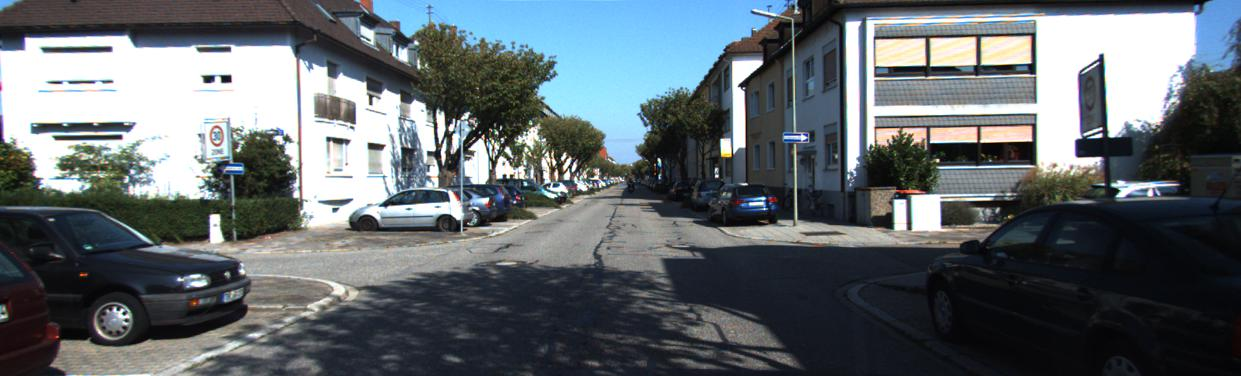

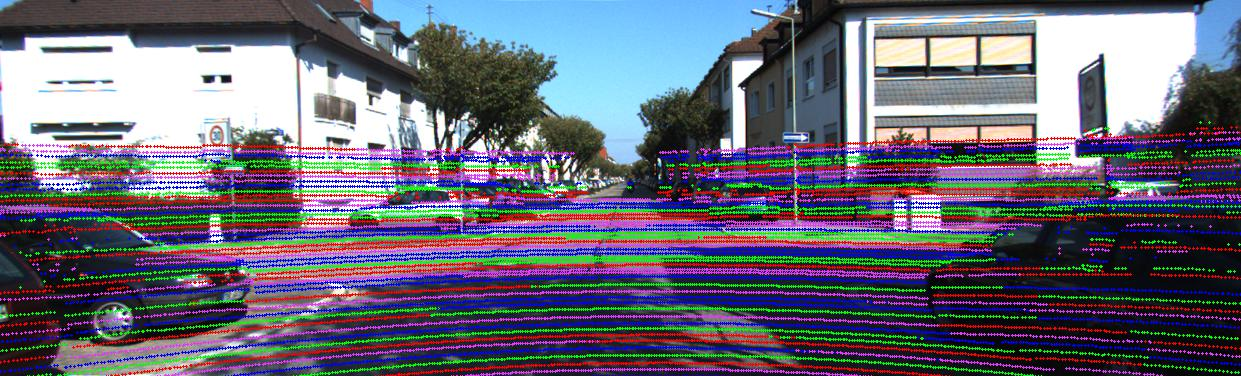

In [120]:
for i in range(dimN) :

    if not retain_indices[i] : continue

    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    sem_label = sem_labels[i]
    #print(sem_label[0])
    #label = labels[sem_label[0]]
    if color[i] == 0:
        R = 255
        G = 0
        B = 0
    elif color[i] == 1:
        R = 0
        G = 255
        B = 0
    elif color[i] == 2:
        R = 0
        G = 0
        B = 255
    elif color[i] == 3:
        R = 230
        G = 55
        B = 255
        
    cv.circle(
        img = image_2_semantic_segmentation,
        center = (x,y),
        radius = 1,
        color = (R,G,B),
        thickness = -1,
        lineType = cv.LINE_AA,
        shift = 0
    )

# write output and show results
cv.imwrite("image_3.png", image_2)
showarray(image_2)
cv.imwrite("image_3_semantic_segmentation.png", image_2_semantic_segmentation)
showarray(image_2_semantic_segmentation)

In [99]:
x_rectified_cam2.shape

(117412, 2)